# Стратификация

## Необходимые модули

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from sklearn.mixture import BayesianGaussianMixture

## Вспомогательные методы

В данном методе формируется генеральная выборка. Пропорция может быть на только для трех компонент, но и, вообще говоря, для любого количества. Мат. ожидание и стандартное отклонение выбираются из равномерного распределения.

In [5]:
def generate_sample(proportion, size, mu_differs, sigma_differs):
    sub_sample_sizes = np.array(list(map(lambda x: int(x * (size / sum(proportion))), proportion)))
    if mu_differs:
        mu_array = np.array([np.random.randint(-100, 100) for i in proportion])
    else:
        mu_array = np.array([np.random.randint(-100, 100)] * len(proportion))
    if sigma_differs:
        sigma_array = np.array([np.random.randint(100) for i in proportion])
    else:
        sigma_array = np.array([np.random.randint(100)] * len(proportion))
    result = np.hstack([np.random.normal(mu_array[i], sigma_array[i], size=sub_sample_sizes[i]) for i in range(len(proportion))])
    np.random.shuffle(result)
    return result

Здесь мы просто генерируем необходимое количество равномерно распределенных индексов, по которым извлекаем элементы из генеральной совокупности.

In [6]:
def simpleSalpmling(generalSample, subSampleSize):
    return np.array([generalSample[i] for i in list(np.random.randint(0, len(generalSample), subSampleSize))])

Здесь функция построена так, что сначала определяются сколько элементов выборки приходится на долю в пропорции, затем определяется, сколько элементов необходимо извлечь из из выборки для каждой компоненты, чтобы в получившейся выборке сохранилась пропорция. Данная функция затем используется в процессе оптимизации с тем, чтобы определить, какая пропорция обеспечивает максимальную похожесть выборки на генеральную совокупность (минимизируется сумма модулей компонент гистограмм для генеральной совокупности и выборки).

In [7]:
def proportional_sampling(proportion, sub_sample_size, general_sample):
    proportion = list(map(ceil, proportion))
    proportion = list(map(int, proportion))
    proportion = list(map(lambda x: x if x > 0 else 1, proportion))
    step = int(len(general_sample) / sum(proportion))
    count_pro_portion = int(sub_sample_size / sum(proportion))
    proportion = np.array(proportion)
    result = np.hstack([
        list(
            map(
                lambda x: general_sample[x],
                np.random.randint(
                    min(step * sum(proportion[:i]), step * sum(proportion[:i + 1])),
                    max(step * sum(proportion[:i]), step * sum(proportion[:i + 1])),
                    count_pro_portion * proportion[i]
                )
            )
        ) for i in range(len(proportion))])
    np.random.shuffle(result)
    return result

In [8]:
def minimization_function(proportion, general_sample):
    hist = np.histogram(general_sample, 50, density=True)[0]
    sub_sample = proportional_sampling(proportion, int(len(general_sample) / 10), general_sample)
    hist1 = np.histogram(sub_sample, 50, density=True)[0]
    return sum(np.abs(hist - hist1))

In [9]:
def minimize_result(initial_proportion, sample):
    res = minimize(
        minimization_function,
        initial_proportion,
        args=(sample),
        method='SLSQP',
        options={'eps': 1.0, 'ftol': 1e-8, 'disp': False},
        bounds=[(1, 10) for i in range(len(initial_proportion))]
    )
    #print(list(map(int, list(map(ceil, res.x)))))
    return list(map(int, list(map(ceil, res.x))))
def minimize_result1(initial_proportion, sample):
    bounds = [(1, 10) for i in initial_proportion]
    minimizer_kwargs = {"method": "SLSQP", "args": sample, "bounds": bounds}
    res = basinhopping(minimization_function, initial_proportion, minimizer_kwargs=minimizer_kwargs, niter=20)
    x = list(map(ceil, res.x))
    x = list(map(int, x))
    x = list(map(lambda x: x if x > 0 else 1, x))
    #print(x)
    return x

Здесь используется байесовская оптимизация с тем, чтобы получить апостериорную оценку распределения и выделить компоненты смеси.

In [10]:
def optimalSampling(generalSample, subSampleSize):
    mixture  = BayesianGaussianMixture(n_components=4, max_iter=int(1e10))
    mixture.fit(generalSample.reshape(-1, 1))
    #print(mixture.get_params())
    sub_sample = mixture.sample(subSampleSize)[0]
    return sub_sample

## Генерация выборки

In [11]:
proportion = (5, 2, 1, 7)
sample = generate_sample(proportion, 1000 * sum(proportion), False, False)

-17.1174863488 47.137249582
-17.6168341404 47.981509137
0.49934779166 -0.844259555031


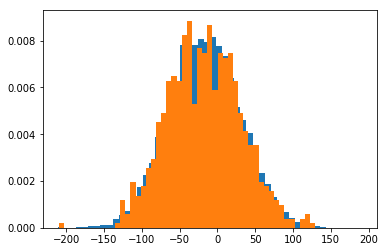

In [12]:
sub_sample = simpleSalpmling(sample, 50 * sum(proportion))
print(sample.mean(), sample.std())
print(sub_sample.mean(), sub_sample.std())
print(sample.mean() - sub_sample.mean(), sample.std() - sub_sample.std())
plt.hist(sample, 50, normed=True)
plt.hist(sub_sample, 50, normed=True)
plt.show()

-17.1174863488 47.137249582
-19.0577646747 47.8464769718
1.94027832595 -0.7092273898


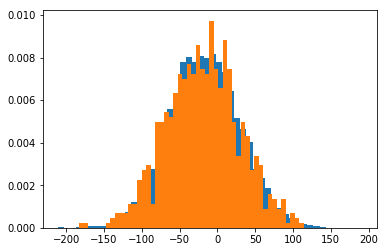

In [13]:
sub_sample = proportional_sampling(minimize_result([1, 1, 1, 1], sample), 50 * sum(proportion), sample)
print(sample.mean(), sample.std())
print(sub_sample.mean(), sub_sample.std())
print(sample.mean() - sub_sample.mean(), sample.std() - sub_sample.std())
plt.hist(sample, 50, normed=True)
plt.hist(sub_sample, 50, normed=True)
plt.show()

-17.1174863488 47.137249582
-17.3070438054 46.1794638035
0.189557456635 0.957785778445


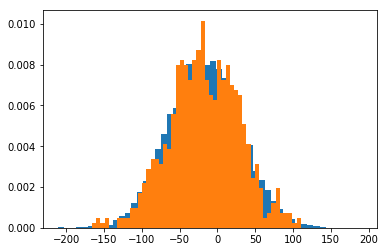

In [14]:
sub_sample = optimalSampling(sample, 50 * sum(proportion))
print(sample.mean(), sample.std())
print(sub_sample.mean(), sub_sample.std())
print(sample.mean() - sub_sample.mean(), sample.std() - sub_sample.std())
plt.hist(sample, 50, normed=True)
plt.hist(sub_sample, 50, normed=True)
plt.show()

In [143]:
%%time
proportion = (5, 2, 1, 7)
n = 50

Wall time: 0 ns


In [144]:
%%time
samples = [generate_sample(proportion, 1000 * sum(proportion), False, False) for i in range(n)]

Wall time: 48.8 ms


In [145]:
%%time
simple_sub_samples = [simpleSalpmling(samples[i], 50 * sum(proportion)) for i in range(n)]

Wall time: 10.9 ms


In [146]:
%%time
proportional_sub_samples = [proportional_sampling(minimize_result([1, 1, 1, 1], samples[i]), 50 * sum(proportion), samples[i]) for i in range(n)]

Wall time: 1.5 s


In [147]:
%%time
optimal_sub_samples = [optimalSampling(samples[i], 50 * sum(proportion)) for i in range(n)]

Wall time: 2min 48s


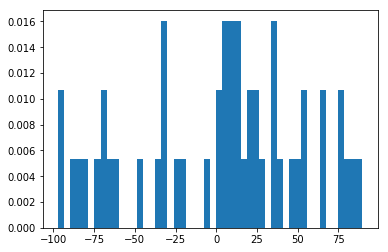

In [148]:
plt.hist(list(map(np.mean, samples)), 50, normed=True)
plt.show()

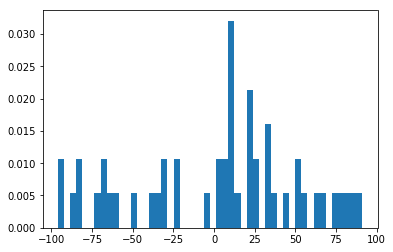

In [149]:
plt.hist(list(map(np.mean, simple_sub_samples)), 50, normed=True)
plt.show()

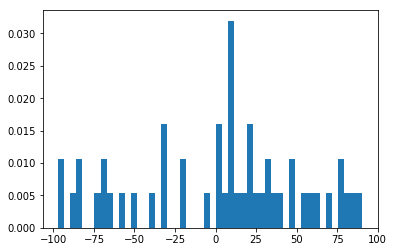

In [150]:
plt.hist(list(map(np.mean, proportional_sub_samples)), 50, normed=True)
plt.show()

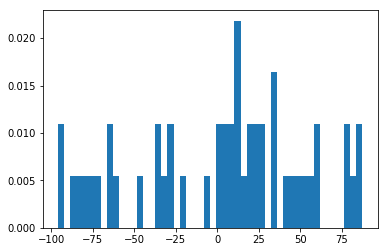

In [151]:
plt.hist(list(map(np.mean, optimal_sub_samples)), 50, normed=True)
plt.show()

In [152]:
hist_samples = np.histogram(list(map(np.mean, samples)), 50, density=True)[0]
hist_simple_sub_samples = np.histogram(list(map(np.mean, simple_sub_samples)), 50, density=True)[0]
hist_proportional_sub_samples = np.histogram(list(map(np.mean, proportional_sub_samples)), 50, density=True)[0]
hist_optimal_sub_samples = np.histogram(list(map(np.mean, optimal_sub_samples)), 50, density=True)[0]

In [153]:
print (sum(np.abs(hist_samples - hist_simple_sub_samples)))
print (sum(np.abs(hist_samples - hist_proportional_sub_samples)))
print (sum(np.abs(hist_samples - hist_optimal_sub_samples)))

0.171239185074
0.171168218605
0.143214348987
